# My Capstone Project: Using Object Detection to Classify Amenities in Vacation Rental Listings

by Jordan Darbyshire

## **Project Overview**

### Motivation

The purpose of this project to identify objects from images of homes uploaded onto vacation rental sites. Potential customers browsing vacation rental sites are looking for specific amenities in their vacation rental. For example, they want an oven to cook in, a pool to swim in, a pool table for entertainment... the list goes on. When a property owner creates an ad on a vacation rental website, they would usually manually type in their amenities or select from a large list. Inaccurate amenities can result in lost revenue due to bad reviews or last-minute cancellations.

Users of the website will search for properties based on their desired amenities, and will be shown a list of properties based on their preferences. What if there was an easier way to add amenities to the listing, simply by uploading the property images without the manual labor? This is where Object Detection come in.

### Inspiration

The inspiration for this project comes from an [article](https://medium.com/airbnb-engineering/amenity-detection-and-beyond-new-frontiers-of-computer-vision-at-airbnb-144a4441b72e) I came across that highlighted an Airbnb computer vision project where they aim to detect room type by the types of objects identified in their listing photos.

I was also interested in this project because of my interest in the Computer Vision field, which is still rapidly evolving. I have a love for travelling, and I have had a lot of experience using these rental sites. 


### Potential Applications

Any hotel or Vacation rental site such as Vrbo, Hotels.com, TripAdvisor, etc.

## **Exploratory Data Analysis**

### About the dataset

The dataset I used for this Capstone project is Open Images V4, which contains 1.99 million images spanning 600 classes. The dataset is open source, put together by Google. It is "the largest existing dataset with object location annotations", it includes bounding boxes manually drawn by humans to ensure accuracy and consistency [Source](https://storage.googleapis.com/openimages/web/factsfigures_v4.html). The images often show complex scenes with several objects (8 annotated objects per image on average) [Source](https://arxiv.org/abs/1811.00982). There are yearly competitions based on this dataset for the purpose of advancing the Computer Vision field.

I chose this dataset due to the large number and variety of the image classes available, and the inclusion of the bounding boxes. If the images did not come with these bounding box "labels", I would have had to create these manually using open source software. To begin this project, I decided that I would choose 20 classes most applicable to this problem. To go about this, I chose the classes most relevant to each room type: Bedroom, Bathroom, Living Room, Kitchen, and Outdoor. On the Open Images website, you are able to download a csv that lists all of the classes contained in this dataset. I filtered the dataset to 30 classes based on what amenities would be the most desirable to the consumer.

### Load packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
import cv2

import warnings
warnings.filterwarnings("ignore")

### Download the images

I quickly realized that the biggest challenge with starting a project for Object Detection is putting together a dataset to run models on. Since the Open Images dataset is so large, it would be a monumental task to download the full dataset (split into 513GB for training, 12GB for validation and 36GB for testing), and sort through it to get what I need. The Open Images website does not provide an option to download select classes of images. Fortunately, I discovered that there are a few open source solutions to this problem. I attempted a few different "toolkits" that promised to solve this problem by downloading only desired classes. I ended up going with the [OIDv4 ToolKit](https://github.com/EscVM/OIDv4_ToolKit) to complete the task.

In [ ]:
# Link to the Toolkit:
#!git clone https://github.com/EscVM/OIDv4_ToolKit.git

The OIDv4 ToolKit finally allowed me to download only the classes I was interested in from the Open Images dataset. Running the OID4 script initiated downloads of the images accompanied with an annotation text file (labels). The annotations have the class of each image and the bounding box coordinates which are used for Object Recognition purposes. Examples of the command to initiate the image downloader are found in the below code cells.

The script below allowed me to simply copy and paste the commands into Anaconda prompt without manually editing each line:

In [ ]:
# Download train set images for desired classes
#for name in classes:   
    #print(f"python main.py downloader --classes {name} --type_csv train --limit 750")

I capped the number of images at 750 after observing some classes had tens of thousands of images, while half of my desired classes had less than 750 for each class.

In [15]:
# Look at count of .jpg files in the dataset folder
import pathlib

data_dir = ("Dataset")
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
image_count 

11907

### Examine the dataset

After completion of the downloading process, I ended up with 11,907 images (3 GB in size).

Each image is accompanied by a text file that has the class name, and bounding box coordinates, in de-normalized image coordinates, meaning the four different values correspond to the actual number of pixels of the related image.

<img src=https://raw.githubusercontent.com/EscVM/OIDv4_ToolKit/master/images/rectangle.png>

### Explore Image Dimensions

In [4]:
# Use OpenCV to read in an image, open a window to view the image
# OpenCV converts the image to a numpy array
example_image = cv2.imread("Dataset/Bathtub/00a60d051d75144f.jpg", cv2.IMREAD_UNCHANGED)

# Opens a window to display the image
cv2.imshow("image",example_image)
# Wait until user presses a key
cv2.waitKey(0)
# Closes window based on waitforkey parameter
cv2.destroyAllWindows() 

In [6]:
# Get dimensions of an image using OpenCV
# This code is from https://www.tutorialkart.com/opencv/python/opencv-python-get-image-size/

# Read an image
image = cv2.imread("Dataset/Bathtub/00a60d051d75144f.jpg", cv2.IMREAD_UNCHANGED)
 
# Get dimensions of image using shape
dimensions = image.shape
 
# height, width, number of channels in image
height = image.shape[0]
width = image.shape[1]
channels = image.shape[2]
pixel_num = image.size
 
print("Image Dimension    : ",dimensions)
print("Image Height       : ",height)
print("Image Width        : ",width)
print("Number of Channels : ",channels)
print("Number of pixels   : ",pixel_num)

Image Dimension    :  (1024, 683, 3)
Image Height       :  1024
Image Width        :  683
Number of Channels :  3
Number of pixels   :  2098176


In [ ]:
# Look at the image array
# print(image)

### Get the dataset into arrays for simple modelling

In [ ]:
# Below code does not work yet

In [ ]:
img_folder_path = "Dataset/train"

In [ ]:
# The below function takes the images from a folder, turns it into an array
# os.path module is sub-module of OS module in Python used for common pathname manipulation
def loadImages(path):
    # Put files into lists and return them as one list of size 4
    image_files = sorted([os.path.join(path, file)
    # Python method listdir() returns a list containing the names of the entries in the directory given by path
         for file in os.listdir(path) if file.endswith(".jpg")])
    return image_files

In [ ]:
image_files

### Visualize the dataset

In [16]:
# This code will read the images from the Dataset folder, put them into a dictionary
# Used code from https://stackoverflow.com/questions/62114998/python-make-dictionary-with-folder-names-as-key-and-file-names-as-values

import fnmatch
from collections import defaultdict

train_dict=defaultdict(set)
for path,dirs,files in os.walk("Dataset"):
   for f in fnmatch.filter(files,'*.jpg'):
      train_dict[os.path.basename(path)].add(f)

# print(dict(train_dict))

In [17]:
# Get number of pictures per class, append values to lists (intermediary step to a DataFrame)
key_list = []
count_list = []

# Get number of photos per class(folder)
for k,v in train_dict.items():
    value = len(list(filter(None, v)))
    key_list.append(k)
    count_list.append(value)

In [18]:
# Used this site as a guide: https://thispointer.com/python-pandas-how-to-convert-lists-to-a-dataframe/
# Create a zipped list of tuples from above lists
zippedList =  list(zip(key_list, count_list))

In [19]:
train_set_df = pd.DataFrame(zippedList, columns = ["Class" , "Image_Count"])

In [20]:
sorted_train_set_df = train_set_df.sort_values(by="Image_Count", ascending=False)

In [21]:
sorted_train_set_df.reset_index(inplace=True, drop=True)
sorted_train_set_df

,Class,Image_Count
0,Bed,749
1,Swimming pool,748
2,Stairs,747
3,Chair,745
4,Lamp,731
5,Couch,727
6,Television,727
7,Table,726
8,Billiard table,666
9,Fireplace,657


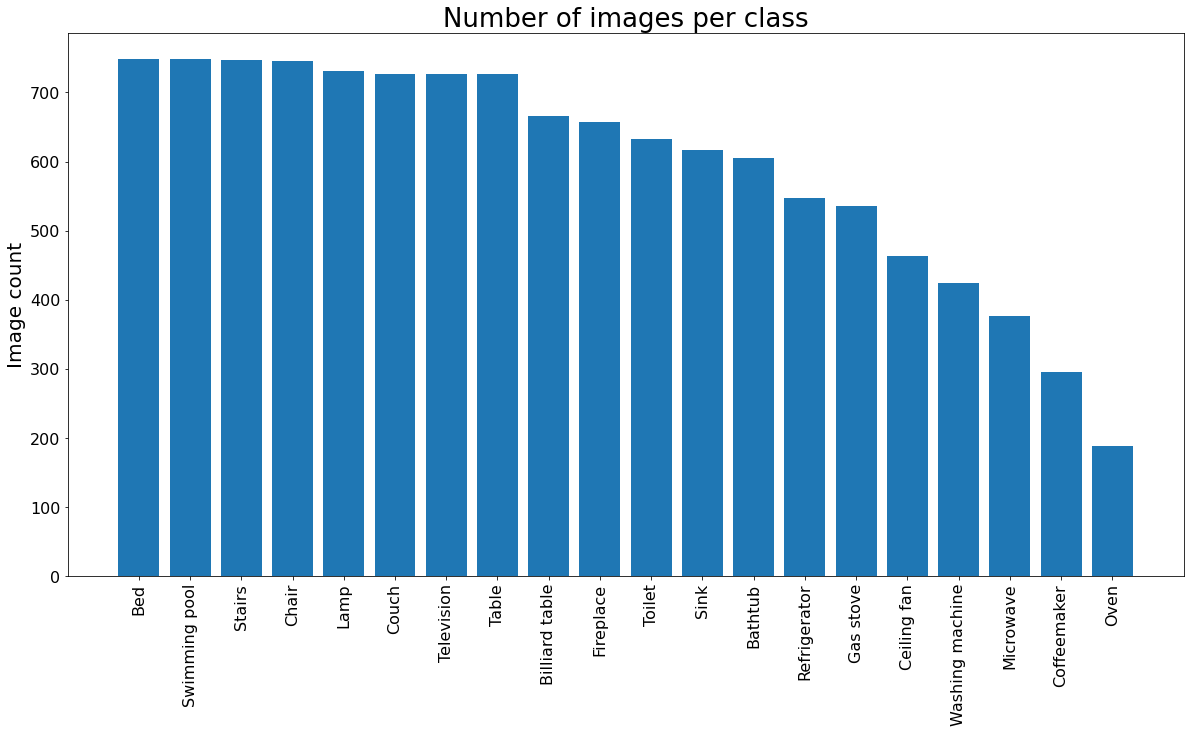

In [32]:
# Make a plot of number of images per class
plt.figure(figsize=(20,10))
plt.bar(sorted_train_set_df["Class"], sorted_train_set_df["Image_Count"])
plt.title("Number of images per class", size=26)
plt.ylabel("Image count", size=20)
plt.xticks(rotation=90, size=16)
plt.yticks(size=16)
plt.show()

## Dataset Challenges

After Exploratory Data Analysis, there are two main concerns with this dataset which could affect training accuracy:
1. Class imbalance
2. Images are in different scales

## **Data Pre-processing**

## Convert annotations to XML format 

In [ ]:
# Download tool to convert txt annotations to PASCAL VOC, run from Anaconda Prompt
#!git clone https://github.com/thehetpandya/OIDv4_annotation_tool.git

In [ ]:
# Now that annotations are in XML (Pascal), need to get them into a single csv file

In [ ]:
# Run the Pascal to CSV program
# Source Code: https://gist.github.com/rotemtam/88d9a4efae243fc77ed4a0f9917c8f6c
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET


def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            bbx = member.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = member.find('name').text

            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     label,
                     xmin,
                     ymin,
                     xmax,
                     ymax
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [ ]:
# Look at the dataset
xml_df = xml_to_csv("Dataset/train/annotations")
xml_df

In [ ]:
# Convert DataFrame to a CSV
# xml_df.to_csv("labels_train.csv")

In [15]:
annotations = pd.read_csv("Dataset/train_labels.csv")

In [16]:
annotations.head()

,Unnamed: 0,filename,width,height,class,xmin,ymin,xmax,ymax
0,0,0000615b5a80f660.jpg,1024,768,Microwave oven,896,200,1023,275
1,1,00011aec5d7324f4.jpg,1024,685,Gas stove,651,342,840,426
2,2,0001cb734adac2ee.jpg,1024,768,Refrigerator,5,5,1020,765
3,3,000325b47e09c6aa.jpg,765,1024,Chair,0,469,128,741
4,4,000325b47e09c6aa.jpg,765,1024,Chair,0,546,183,960


## Train/set split

I used a script called "partition_dataset.py" from GitHub to partition the image and XML data into 80-20 Train-test split. I ran the command below in Anaconda Prompt to split the data.

python partition_dataset.py -i Dataset\Bathtub -o Dataset/_partitioned -r 0.2 -x

In [ ]:
#!git clone https://github.com/armaanpriyadarshan/Training-a-Custom-TensorFlow-2.X-Object-Detector.git

## Prepare inputs for TensorFlow

Instructions taken from the [Tensorflow Object Detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/using_your_own_dataset.md):
1. Create Label Maps
2. Convert dataset to TFRecord file format

For every example in dataset, we need:\
    - An RGB image for the dataset encoded as jpeg or png.\
    - A list of bounding boxes for the image. Each bounding box should contain:\
        i. A bounding box coordinates (with origin in top left corner) defined by 4 floating point numbers - ymin, xmin, ymax, xmax. Note that we need to store the normalized coordinates (x / width, y / height) in the TFRecord dataset.\
        ii. The class of the object in the bounding box.


**1. Create Label Maps** Now that the annotations are in CSV format, we also need to create a label map which is required to make TFRecords out of dataset.

In [ ]:
s = pd.Series(sorted_train_set_df["Class"])
class_list = s.values.tolist()
print(class_list)
len(class_list)

In [ ]:
# Example of converting python list to label_map.pbtxt
# Source: https://github.com/tensorflow/models/issues/1601

from object_detection.protos.string_int_label_map_pb2 import StringIntLabelMap, StringIntLabelMapItem
from google.protobuf import text_format


def convert_classes(classes, start=1):
    msg = StringIntLabelMap()
    for id, name in enumerate(classes, start=start):
        msg.item.append(StringIntLabelMapItem(id=id, name=name))

    text = str(text_format.MessageToBytes(msg, as_utf8=True), 'utf-8')
    return text


if __name__ == '__main__':
    txt = convert_classes(class_list)
    print(txt)
    with open('label_map.pbtxt', 'w') as f:
        f.write(txt)

**2. Convert dataset to TFRecord file format**

Using the Label Map, can generate a tf.Example proto for images using a script based on the TensorFlow Object Detector API. I cloned the following repository, and used the "generate_tfrecord.py" script. 

In [ ]:
#!git clone https://github.com/armaanpriyadarshan/Training-a-Custom-TensorFlow-2.X-Object-Detector.git

python generate_tfrecord.py -x workspace\capstone\images\train -l workspace\capstone\annotations\label_map.pbtxt -o workspace\capstone\annotations\train.record

## **Model Training**

## Train dataset with pre-trained models

I decided to make use of the CUDA-enabled GPU on my laptop to run the pre-trained models.

In [ ]:
# Import TensorFlow
import tensorflow as tf
from tensorflow import keras

In [3]:
# Show the TensorFlow version
print(tf.__version__)

2.3.0


Turn on memory growth for GPU by running the following code prior to allocating any tensors or executing any ops [Source: TensorFlow - Using a GPU](https://www.tensorflow.org/guide/gpu). Attempts to allocate only as much GPU memory as needed for the runtime allocations.

In [4]:
# Run the following code before executing anything
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


## Pre-trained model no. 1: ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8

### Model Description:

Released in 2019, this model is a Single Shot Detector (SSD) model that goes straight from image pixels to bounding box coordinates and class probabilities. By using SSD, we only need to take one single shot to detect multiple objects within the image. Compare this to R-CNN that needs two shots, one for generating region proposals, one for detecting the object of each proposal. Thus, SSD is much faster compared with two-shot RPN based approaches. [Source](https://towardsdatascience.com/review-ssd-single-shot-detector-object-detection-851a94607d11). The model architecture is based on inverted residual structure where the input and output of the residual block are thin bottleneck layers as opposed to traditional residual models. Moreover, nonlinearities are removed from intermediate layers and lightweight depthwise convolution is used. This model is part of the Tensorflow object detection API. [Source](https://resources.wolframcloud.com/NeuralNetRepository/resources/SSD-MobileNet-V2-Trained-on-MS-COCO-Data)

The SSD Mobilenet V2 is an Object detection model with FPN-lite feature extractor, shared box predictor and focal loss, trained on COCO 2017 dataset with training images scaled to 640x640 [Source](https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1). Focal loss is very useful for dealing with class imbalance, especially in object detection tasks. The loss function is a dynamically scaled cross-entropy loss, where the scaling factor decays to zero as confidence in the correct class increases. [Source](https://medium.com/analytics-vidhya/how-focal-loss-fixes-the-class-imbalance-problem-in-object-detection-3d2e1c4da8d7)

<img src=https://cdn-images-1.medium.com/max/1000/1*GmJiirxTSuSVrh-r7gtJdA.png>

In [3]:
# Test Tensorflow
tf.add(1, 2).numpy()
#3
hello = tf.constant('Hello, TensorFlow!')
hello.numpy()
#b'Hello, TensorFlow!'

b'Hello, TensorFlow!'

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Pre-trained model no. 2: Faster R-CNN

In Faster R-CNN, region proposal generation and object detection tasks are all done by the same convolutional networks (10x faster than 

<img src=https://miro.medium.com/max/548/1*e6dx5qzUKWwasIVGSuCyDA.png>

1. 

## Pre-trained model no. 3: ?

### Get Images into Numpy Arrays

In order for Images to go into a TensorFlow model, they to be read and decoded into integer tensors, then converted to floating point and normalized to small values (between 0 and 1).

In [ ]:
# The below function converts all of the images into numpy arrays
from PIL import Image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [ ]:
from PIL import Image
# We need to get all of the images into arrays, which will be used to combine with the bounding boxes & labels
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)

#### Scale the data

We need to “Normalize” pixel values (integers between 0-255) to values between 0 and 1 by dividing all pixel values by 255. 
Why? Because large integer values can slow down the ML process. Neural networks process inputs using small weight values )

In [ ]:
# 

X_train = X_train / 255
X_test = X_test / 255

## **Tensorflow Models**